📊 Original columns: ['vehicle_age', 'vehicle_condition_score', 'trade_in_history', 'incentive_received', 'mileage', 'customer_engagement_score', 'exchange', 'vehicle_age_squared', 'is_high_mileage', 'engagement_to_age_ratio']


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:15:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Selected Top 7 Features: ['is_trade_in_with_incentive', 'adjusted_engagement', 'vehicle_condition_score', 'incentive_received', 'trade_in_history', 'customer_engagement_score', 'incentive_per_condition']


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:15:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report (Top 7 Features):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     28931
           1       0.87      0.82      0.84     11069

    accuracy                           0.92     40000
   macro avg       0.90      0.89      0.89     40000
weighted avg       0.92      0.92      0.92     40000



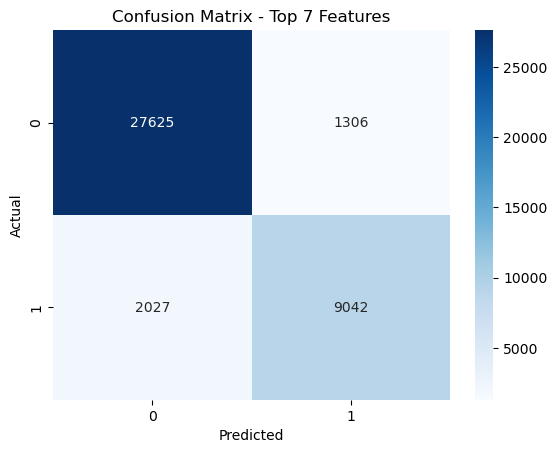

✅ Model saved to S3 at s3://test-bucket-05-ak/cvee_poc/models/xgb_model.pkl
✅ Predictions saved to S3 at s3://test-bucket-05-ak/cvee_poc/output/predictions_with_columns.csv


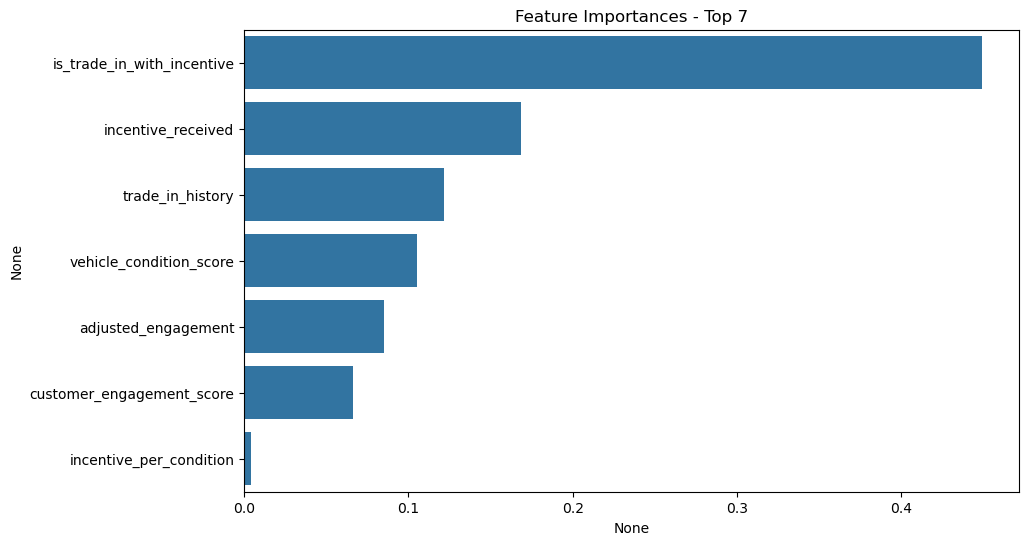

📊 Available columns: ['vehicle_age', 'vehicle_condition_score', 'trade_in_history', 'incentive_received', 'mileage', 'customer_engagement_score', 'exchange', 'vehicle_age_squared', 'is_high_mileage', 'engagement_to_age_ratio']
📊 Available columns after feature engineering: ['vehicle_age', 'vehicle_condition_score', 'trade_in_history', 'incentive_received', 'mileage', 'customer_engagement_score', 'exchange', 'vehicle_age_squared', 'is_high_mileage', 'engagement_to_age_ratio']


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:15:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Selected Top 7 Features: ['trade_in_history', 'incentive_received', 'customer_engagement_score', 'vehicle_condition_score', 'engagement_to_age_ratio', 'mileage', 'vehicle_age']


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:15:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report (Top 7 Features):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     28931
           1       0.87      0.82      0.84     11069

    accuracy                           0.92     40000
   macro avg       0.90      0.89      0.89     40000
weighted avg       0.92      0.92      0.92     40000



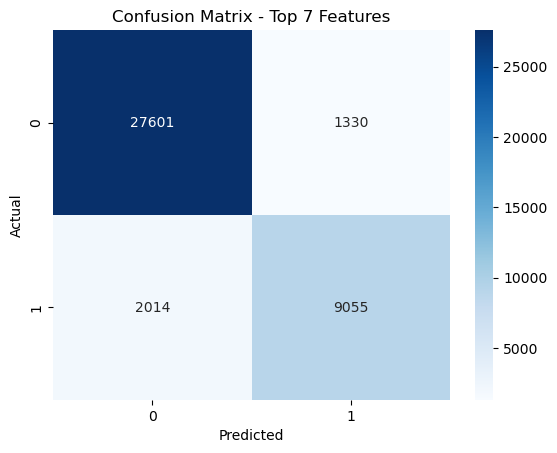

✅ Model saved to S3 at s3://test-bucket-05-ak/cvee_poc/models/xgb_model.pkl
✅ Predictions saved to S3 at s3://test-bucket-05-ak/cvee_poc/output/predictions_with_columns.csv


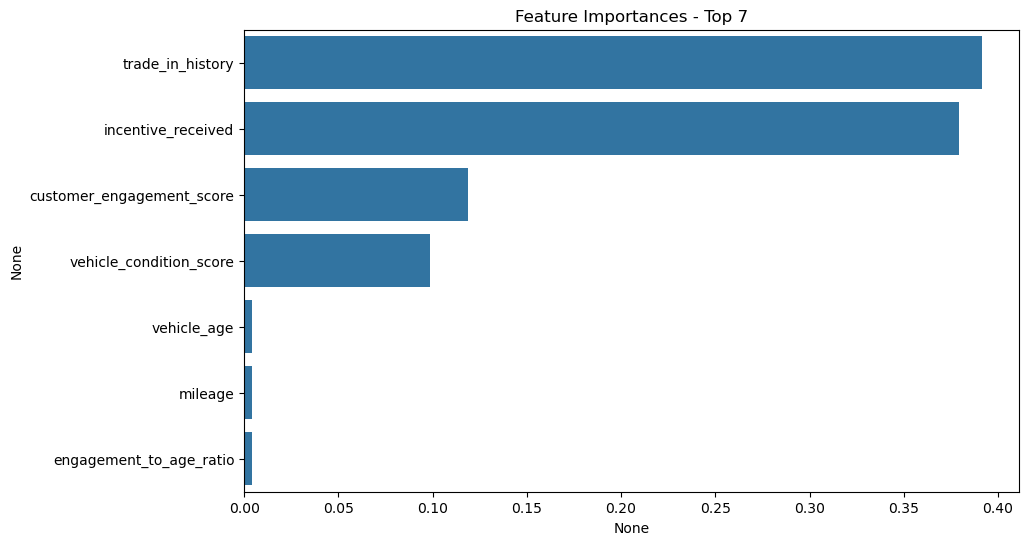

In [3]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from io import StringIO
import boto3

# 🪣 S3 Setup
s3 = boto3.client('s3')
bucket_name = 'test-bucket-05-ak'
input_key = 'cvee_poc/input/exchange_dataset_enhanced.csv'
model_key = 'cvee_poc/models/xgb_model.pkl'
output_key = 'cvee_poc/output/predictions_with_columns.csv'

# 📥 Load Dataset from S3
obj = s3.get_object(Bucket=bucket_name, Key=input_key)
df = pd.read_csv(obj['Body'])

# 📊 Show original columns
print("📊 Original columns:", df.columns.tolist())

# 🛠️ Feature Engineering
df['age_condition_interaction'] = df['vehicle_age'] * df['vehicle_condition_score']
df['engagement_per_mile'] = df['customer_engagement_score'] / (df['mileage'] + 1)
df['incentive_per_condition'] = df['incentive_received'] / (df['vehicle_condition_score'] + 1)
df['is_trade_in_with_incentive'] = np.where((df['trade_in_history'] == 1) & (df['incentive_received'] > 0), 1, 0)
df['adjusted_engagement'] = df['customer_engagement_score'] * df['vehicle_condition_score']

# 🧼 Handle missing values
df.dropna(inplace=True)

# 🧠 Define Features and Target
X = df.drop('exchange', axis=1)
y = df['exchange']

# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🚀 Train Initial Model for Feature Importance
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 🌟 Get Top 7 Features
importances = model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
top_7_features = feat_imp.head(7).index.tolist()
print("✅ Selected Top 7 Features:", top_7_features)

# 🔁 Re-train with Top 7 Features
X_train_top7 = X_train[top_7_features]
X_test_top7 = X_test[top_7_features]

model_top7 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_top7.fit(X_train_top7, y_train)

y_pred_top7 = model_top7.predict(X_test_top7)

# 📊 Evaluation
print("\n📊 Classification Report (Top 7 Features):")
print(classification_report(y_test, y_pred_top7))

# 🧮 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_top7)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Top 7 Features")
plt.show()

# 💾 Save Model to S3
model_file = '/tmp/xgb_model_top7.pkl'
joblib.dump(model_top7, model_file)
s3.upload_file(model_file, bucket_name, model_key)
print(f"✅ Model saved to S3 at s3://{bucket_name}/{model_key}")

# 📝 Save Predictions to S3
X_test_copy = X_test_top7.copy()
X_test_copy['actual'] = y_test.values
X_test_copy['predicted'] = y_pred_top7

csv_buffer = StringIO()
X_test_copy.to_csv(csv_buffer, index=False)
s3.put_object(Bucket=bucket_name, Key=output_key, Body=csv_buffer.getvalue())
print(f"✅ Predictions saved to S3 at s3://{bucket_name}/{output_key}")

# 📈 Feature Importance Plot
feat_imp_top7 = pd.Series(model_top7.feature_importances_, index=top_7_features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp_top7, y=feat_imp_top7.index)
plt.title("Feature Importances - Top 7")
plt.show()

# 📥 Load Dataset from S3
obj = s3.get_object(Bucket=bucket_name, Key=input_key)
df = pd.read_csv(obj['Body'])

# 📊 Show columns
print("📊 Available columns:", df.columns.tolist())

# 🛠️ Feature Engineering (safe conditional logic)
if 'customer_age' in df.columns and 'customer_engagement_score' in df.columns:
    df['engagement_to_age_ratio'] = df['customer_engagement_score'] / (df['customer_age'] + 1)

if 'signup_date' in df.columns and 'last_transaction_date' in df.columns:
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_transaction_date'] = pd.to_datetime(df['last_transaction_date'])
    df['customer_lifetime_days'] = (df['last_transaction_date'] - df['signup_date']).dt.days

if 'transaction_count' in df.columns and 'customer_lifetime_days' in df.columns:
    df['txn_per_day'] = df['transaction_count'] / (df['customer_lifetime_days'] + 1)

if 'customer_engagement_score' in df.columns and 'transaction_count' in df.columns:
    df['engagement_per_txn'] = df['customer_engagement_score'] / (df['transaction_count'] + 1)

if 'avg_transaction_value' in df.columns and 'transaction_count' in df.columns and 'customer_lifetime_days' in df.columns:
    df['revenue_per_day'] = (df['avg_transaction_value'] * df['transaction_count']) / (df['customer_lifetime_days'] + 1)

if 'email_open_rate' in df.columns and 'customer_engagement_score' in df.columns:
    df['marketing_score'] = df['email_open_rate'] * df['customer_engagement_score']


# 📊 Show columns
print("📊 Available columns after feature engineering:", df.columns.tolist())

# 🧼 Drop missing values
df.dropna(inplace=True)

# 🧠 Define Features and Target
X = df.drop('exchange', axis=1)
y = df['exchange']

# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🚀 Train Initial Model for Feature Importance
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 🌟 Get Top 7 Features
importances = model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
top_7_features = feat_imp.head(7).index.tolist()
print("✅ Selected Top 7 Features:", top_7_features)

# 🔁 Re-train with Top 7 Features
X_train_top7 = X_train[top_7_features]
X_test_top7 = X_test[top_7_features]

model_top7 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_top7.fit(X_train_top7, y_train)

y_pred_top7 = model_top7.predict(X_test_top7)

# 📊 Evaluation
print("\n📊 Classification Report (Top 7 Features):")
print(classification_report(y_test, y_pred_top7))

# 🧮 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_top7)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Top 7 Features")
plt.show()

# 💾 Save Model to S3
model_file = '/tmp/xgb_model_top7.pkl'
joblib.dump(model_top7, model_file)
s3.upload_file(model_file, bucket_name, model_key)
print(f"✅ Model saved to S3 at s3://{bucket_name}/{model_key}")

# 📝 Save Predictions to S3
X_test_copy = X_test_top7.copy()
X_test_copy['actual'] = y_test.values
X_test_copy['predicted'] = y_pred_top7

csv_buffer = StringIO()
X_test_copy.to_csv(csv_buffer, index=False)
s3.put_object(Bucket=bucket_name, Key=output_key, Body=csv_buffer.getvalue())
print(f"✅ Predictions saved to S3 at s3://{bucket_name}/{output_key}")

# 📈 Feature Importance Plot (Top 7 Only)
feat_imp_top7 = pd.Series(model_top7.feature_importances_, index=top_7_features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp_top7, y=feat_imp_top7.index)
plt.title("Feature Importances - Top 7")
plt.show()
